In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import cmath
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 7);

Populating the interactive namespace from numpy and matplotlib


In [2]:
countByDay = pd.read_csv('data\out_countByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')
posByDay = pd.read_csv('data\out_posByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')
neutrByDay = pd.read_csv('data\out_neutrByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')
negByDay = pd.read_csv('data\out_negByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')

In [3]:
#create dimensionless values
ftse = pd.read_csv('data\FTSE.csv', header=0, parse_dates=[0]).sort_values(by = 'Date')
ftse = ftse[['Date', 'Adj Close', 'Volume']]
ftse.columns = ['day', 'price', 'volume']
ftse.head()

,day,price,volume
0,2015-02-11,6818.200195,623275800
1,2015-02-12,6828.100098,809863300
2,2015-02-13,6873.500000,734854200
3,2015-02-16,6857.100098,415979100
4,2015-02-17,6898.100098,612932700


In [4]:
ftse['priceDl'] = ftse['price'].apply(lambda x: x / ftse['price'][0])
ftse['volumeDl'] = ftse['volume'].apply(lambda x: x / ftse['volume'][0])
ftse['complex'] = ftse['priceDl'] + ftse['volumeDl'] * 1j
ftse.head()

,day,price,volume,priceDl,volumeDl,complex
0,2015-02-11,6818.200195,623275800,1.000000,1.000000,(1+1j)
1,2015-02-12,6828.100098,809863300,1.001452,1.299366,(1.001451981859855+1.2993658666035164j)
2,2015-02-13,6873.500000,734854200,1.008111,1.179019,(1.008110616206393+1.1790193041347026j)
3,2015-02-16,6857.100098,415979100,1.005705,0.667408,(1.0057053037293517+0.6674077511111454j)
4,2015-02-17,6898.100098,612932700,1.011719,0.983405,(1.0117186208551918+0.9834052597582001j)


In [5]:
results = pd.merge(posByDay, neutrByDay, on='day')
results = pd.merge(results, negByDay, on='day')
results.columns = ['day', 'positive', 'neutral', 'negative']
results.head()

,day,positive,neutral,negative
0,2016-02-24,738,4624,2511
1,2016-02-25,1138,6670,3583
2,2016-02-26,952,5775,3287
3,2016-02-27,804,4578,2360
4,2016-02-28,1057,5172,2616


In [6]:
results["diff"] = (results["positive"] - results["negative"])/(results["positive"] + results["neutral"] + results["negative"])
results.head()

,day,positive,neutral,negative,diff
0,2016-02-24,738,4624,2511,-0.225200
1,2016-02-25,1138,6670,3583,-0.214643
2,2016-02-26,952,5775,3287,-0.233174
3,2016-02-27,804,4578,2360,-0.200982
4,2016-02-28,1057,5172,2616,-0.176258


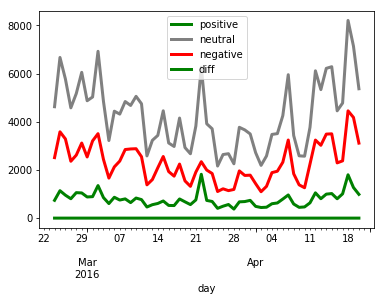

In [7]:
results.plot(x='day', linewidth = 3, color=['g', 'gray', 'r'])

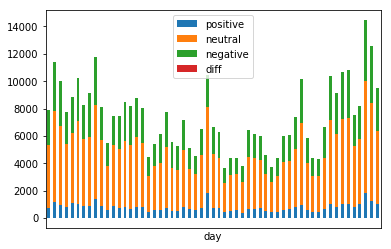

In [8]:
results.plot.bar(x='day', stacked=True);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [9]:
allRes = pd.merge(results[["day", "diff"]], ftse, on = 'day')
allRes.head()

,day,diff,price,volume,priceDl,volumeDl,complex
0,2016-02-24,-0.225200,5867.200195,834682500,0.860520,1.339186,(0.8605203759347815+1.339186440416907j)
1,2016-02-25,-0.214643,6012.799805,999956900,0.881875,1.604357,(0.881874927845236+1.6043570117755255j)
2,2016-02-26,-0.233174,6096.000000,858937600,0.894078,1.378102,(0.8940775902224736+1.3781019574320068j)
3,2016-02-29,-0.202879,6097.100098,941705500,0.894239,1.510897,(0.8942389374942663+1.5108969416107605j)
4,2016-03-01,-0.200386,6152.899902,933626200,0.902423,1.497934,(0.9024228866896742+1.4979343013157258j)


## Нахождение коэффициента парной корреляции 

In [10]:
def rc(y,x):
    #Центрирование
    yr = y.real - y.real.mean()
    yi = y.imag - y.imag.mean()
    xr = x.real - x.real.mean()
    xi = x.imag - x.imag.mean()
    
#     print(y.real.mean())    
#     print(y.imag.mean())
#     print(x.real.mean())
#     print(x.imag.mean())
    
    rc_xy = (
        ((yr + 1j*yi)*(xr + 1j*xi)).sum()
        / 
        sqrt(((yr + 1j*yi)**2).sum() * ((xr + 1j*xi)**2).sum())
        )
    return rc_xy;

In [11]:
y = pd.DataFrame({"y":[(1+3j),(2+2j),(3+3j)],
                  "x":[(1+1j),(2+4j),(3+3j)]})
print(rc(y['y'], y['x']))
print(np.corrcoef(y['y'], y['x'])[0][1])

(1.317736781254481-0.7880644702600822j)
(0.15811388300841897-0.474341649025257j)


In [12]:
y = pd.DataFrame({"y":[(1+0j),(2+2j)],
                  "x":[(0+1j),(1+2j)]})
print(rc(y['y'], y['x']))
print(np.corrcoef(y['y'], y['x'])[0][1])

(-1-0j)
(0.9486832980505138+0.31622776601683794j)


In [13]:
allRes.columns = ['date', 'sentimentCoef', 'price', 'volume', 'priceDl', 'volumeDl', 'complex']
allRes = allRes.sort_values(by = 'date')
allRes.head()

,date,sentimentCoef,price,volume,priceDl,volumeDl,complex
0,2016-02-24,-0.225200,5867.200195,834682500,0.860520,1.339186,(0.8605203759347815+1.339186440416907j)
1,2016-02-25,-0.214643,6012.799805,999956900,0.881875,1.604357,(0.881874927845236+1.6043570117755255j)
2,2016-02-26,-0.233174,6096.000000,858937600,0.894078,1.378102,(0.8940775902224736+1.3781019574320068j)
3,2016-02-29,-0.202879,6097.100098,941705500,0.894239,1.510897,(0.8942389374942663+1.5108969416107605j)
4,2016-03-01,-0.200386,6152.899902,933626200,0.902423,1.497934,(0.9024228866896742+1.4979343013157258j)


In [14]:
print('rc volume-volume:     ' + str(rc(allRes['complex'],
                                    allRes['complex'])))

print('rc volume-price:      ' + str(rc(allRes['complex'],
                                    allRes['priceDl'])))

print('rc price-volume*1000: ' + str(rc(allRes['complex'],
                                    allRes['priceDl']*1000)))

rc volume-volume:     (-1+0j)
rc volume-price:      (0.16822102035413533+0.06301011518149292j)
rc price-volume*1000: (0.16822102035413466+0.06301011518149296j)


In [15]:
#rc
print(rc(allRes['volume'], allRes['price']))
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['volume'], allRes['price'])[0][1])

(-0.1671953407932242+0j)
-0.16719534079322415


In [16]:
startShift = -14
endShift = 14
rcdf = pd.DataFrame(columns=('shift', 'rc'))

for i in range(startShift, endShift+1):
    if (i < 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['sentimentCoef'].iloc[:i],
                                  allRes['complex'].shift(i).iloc[:i])]})
    elif (i == 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['sentimentCoef'],
                                  allRes['complex'])]})
    else:    
        row = pd.DataFrame({"shift":[i], 
                        "rc": [rc(allRes['sentimentCoef'].iloc[i:],
                                  allRes['complex'].shift(i).iloc[i:])]})

    rcdf = rcdf.append(row, ignore_index=True)
    
rcdf

,shift,rc
0,-14,(0.22255335501586926-0.03216258508871702j)
1,-13,(0.06716304823544697-0.026251253484148463j)
2,-12,(-0.27161430550349835-0.02881834334558945j)
3,-11,(0.007811562467985368-0.016471652628619708j)
4,-10,(0.2070582237507672-0.004280268971532546j)
5,-9,(0.034651347242466386-0.005509218639810538j)
6,-8,(0.028166420236788347+0.009525044357633395j)
7,-7,(-0.3413403917821899+0.0033670817187269352j)
8,-6,(-0.15317524638969587+0.006612501986584837j)
9,-5,(-0.1089929177970289-0.008362432747180302j)


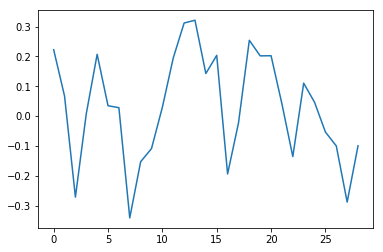

In [17]:
rcdf['rc'].apply(lambda x: x.real).plot()

## Нормирование результатов

In [18]:
allRes["sentimentCoefNorm"] = ((allRes["sentimentCoef"] - allRes["sentimentCoef"].min()) / 
                        (allRes["sentimentCoef"].max() - allRes["sentimentCoef"].min()))
allRes["priceNorm"] = ((allRes["price"] - allRes["price"].min()) / 
                        (allRes["price"].max() - allRes["price"].min()))
allRes["volumeNorm"] = ((allRes["volume"] - allRes["volume"].min()) / 
                        (allRes["volume"].max() - allRes["volume"].min()))

In [19]:
#Стандартная функция для нахождения корреляции
np.corrcoef(allRes['volumeNorm'], allRes['priceNorm'])[0][1]

-0.1671953407932242

In [20]:
print('rc volumeNorm-priceNorm: ' + str(rc(allRes['volumeNorm'],
                                           allRes['priceNorm'])))

rc volumeNorm-priceNorm: (-0.16719534079322423+0j)


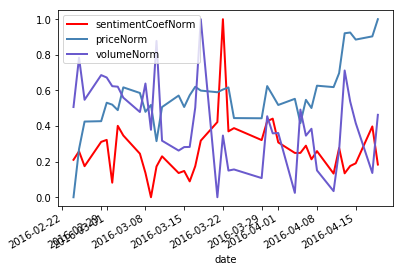

In [21]:
allRes[['date', 'sentimentCoefNorm', 'priceNorm', 'volumeNorm']].plot(x='date', 
                                                                      linewidth = 2, 
                                                                      color = ['r', 'steelblue', 'slateblue'])